In [260]:
from IPython.display import display, HTML

display(
    HTML("""
<style>
* {font-family:D2Coding;}
div.container{width:87% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input { font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:3px;}
table.dataframe{font-size:12px;}
</style>
"""))

In [261]:
import numpy as np
import pandas as pd
import sys
from tensorflow.keras.utils import to_categorical # 원화인코딩
from tensorflow.keras.models import Sequential, save_model, load_model # 모델생성
from tensorflow.keras.layers import Input, Dense, Dropout
from matplotlib import pyplot as plt # 학습 과정 그래프
from sklearn.metrics import confusion_matrix # 행동행렬
from sklearn.preprocessing import MinMaxScaler, StandardScaler # 스케일 조정
from sklearn.model_selection import train_test_split # 데이터 분리

<font size=5 color=red>07_심장병발병예측(이진,분류)</font>

# 이진 분류
```
1. 데이터 셋 생성 & 전처리
    엑셀 -> 데이터프레임 -> 전처리(df.replace('?', np.nan) -> 결측치 처리
     -> x, y 분리 -> x변수 스케일 조정 -> train_test_split함수로 학습셋과 테스트분
2. 모델생성 (입력13개, 출력 1개) & 학습과정 설정 & 학습
3. 모델 평가 (그래프, 교차표)
4. 모델 사용(저장, 에측)
```

## 컬럼명 의미 및 설명
- cp 흉통의 유형 (Chest Pain type)
    - 0: 전형적 협심증 / 1: 비전형적 협심증 / 2: 비심장성 흉통 / 3: 무증상
- treshtbps 안정 시 수축기 혈압 (Resting Blood Pressure in mm Hg)
- chol 혈청 콜레스테롤 수치 (Serum Cholesterol in mg/dl)
- fbs 공복혈당 120mg/dl 이상 여부 (Fasting Blood Sugar) - 1: Yes, 0: No
- restecg 안정 시 심전도 결과 (Resting Electrocardiographic Results)
    - 0: 정상 / 1: ST-T 이상 / 2: 좌심실 비대 가능성
- thalach 최대 심박수 (Maximum Heart Rate Achieved)
- exang 운동 중 협심증 여부 (Exercise Induced Angina) - 1: 있음, 0: 없음
- oldpeak 운동 후 ST 감소 정도 (ST Depression induced by exercise relative to rest)
- slope ST segment의 기울기 (Slope of the peak exercise ST segment)
    - 1: 수평 / 2: 상승 / 3: 하강
- ca 형광투시검사에서 관찰된 주요 혈관 수 (Number of major vessels colored by fluoroscopy)
- hsl (일반적으로 thal로 표기됨) 지혈소 상태 (Thalassemia)
    - 3: 정상 / 6: 고정결함 / 7: 가역적 결함
- heartDisease 심장병 여부 (Target Variable)
    - 1: 심장병 있음 / 0: 없음

## 1. 데이터 셋 생성 & 전처리

- 엑셀 -> 데이터프레임 -> ?처리(df.replace('?',np.nan) -> 결측치 처리
    - X, y 분리 -> X변수 스케일조정 -> train_test_split함수로 학습셋과 테스트셋분리

In [262]:
dataset = pd.read_excel('./data/heart-disease.xlsx')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          303 non-null    object 
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            303 non-null    object 
 12  hsl           303 non-null    object 
 13  heartDisease  303 non-null    int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 33.3+ KB


In [263]:
dataset.isin(['?']).any() # 물음표가 있는 열 여부

age             False
sex             False
cp              False
treshtbps       False
chol             True
fbs             False
restecg         False
thalach         False
exang           False
oldpeak         False
slope           False
ca               True
hsl              True
heartDisease    False
dtype: bool

In [264]:
# '?'가 포함된 데이터 추출
dataset[(dataset['chol']=='?') | (dataset['ca']=='?') | (dataset['hsl']=='?')]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,?,0,2,129,1,2.6,2,2,7,1
87,53,0,3,128,216,0,2,115,0,0.0,1,0,?,0
166,52,1,3,138,223,0,0,169,0,0.0,1,?,3,0
192,43,1,4,132,247,1,2,143,1,0.1,2,?,7,1
266,52,1,4,128,204,1,0,156,1,1.0,2,0,?,1
287,58,1,2,125,220,0,0,144,0,0.4,2,?,7,0
302,38,1,3,138,175,0,0,173,0,0.0,1,?,3,0


In [265]:
# '?'를 결측치(np.nan)로 대체
df = dataset.replace('?', np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          302 non-null    float64
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            299 non-null    float64
 12  hsl           301 non-null    float64
 13  heartDisease  303 non-null    int64  
dtypes: float64(4), int64(10)
memory usage: 33.3 KB


In [266]:
# 결측치가 포함된 데이터 추출
df[df.isna().any(axis=1)]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,NaN,0,2,129,1,2.6,2,2.0,7.0,1
87,53,0,3,128,216.0,0,2,115,0,0.0,1,0.0,NaN,0
166,52,1,3,138,223.0,0,0,169,0,0.0,1,NaN,3.0,0
192,43,1,4,132,247.0,1,2,143,1,0.1,2,NaN,7.0,1
266,52,1,4,128,204.0,1,0,156,1,1.0,2,0.0,NaN,1
287,58,1,2,125,220.0,0,0,144,0,0.4,2,NaN,7.0,0
302,38,1,3,138,175.0,0,0,173,0,0.0,1,NaN,3.0,0


In [267]:
# 결측치 처리 : 대체 or 제거
df.fillna(value=df.median(), inplace=True) # 결측치를 중위수로 대체
# df = df.dropna(how='any')  #결측치 제거
df.isna().sum() # 결측치가 없는지 확인

/var/folders/sr/fzxv95r54q53nl86rhm2c0zc0000gn/T/ipykernel_3404/1275841749.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.fillna(value=df.median(), inplace=True) # 결측치를 중위수로 대체


age             0
sex             0
cp              0
treshtbps       0
chol            0
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              0
hsl             0
heartDisease    0
dtype: int64

In [268]:
# 입력변수와 타겟변수 분리
X = df.iloc[:, :-1].values
y = df.iloc[:, -1:].values
X.shape, y.shape

((303, 13), (303, 1))

In [269]:
# 입력변수 X의 스케일 조정
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
scaled_X[:2]

array([[0.70833333, 1.        , 0.        , 0.48113208, 0.24429224,
        1.        , 1.        , 0.60305344, 0.        , 0.37096774,
        1.        , 0.        , 0.75      ],
       [0.79166667, 1.        , 1.        , 0.62264151, 0.3652968 ,
        0.        , 0.        , 0.28244275, 1.        , 0.24193548,
        0.5       , 1.        , 0.        ]])

In [270]:
#scaled_X, y를 학습셋:테스트셋=7:3으로 분할
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X,
    y,
    test_size=0.3,  # 테스트셋 비율
    random_state=7,
    stratify=y  # 충화추출
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((212, 13), (91, 13), (212, 1), (91, 1))

In [271]:
# 음성 | 양성 비율
print(pd.DataFrame(y).value_counts(normalize=True))  # 전체비율
print(pd.DataFrame(Y_train).value_counts(normalize=True))  # Y_train
print(pd.DataFrame(y_test).value_counts(normalize=True))  # y_test

0    0.541254
1    0.458746
dtype: float64
0    1  
1.0  0.0    0.542453
0.0  1.0    0.457547
dtype: float64
0    0.538462
1    0.461538
dtype: float64


## 2. 모델생성(입력13, 출력1) & 학습과정 설정 & 학습

- 그래프를 보고, 과적합 줄이기 추가할 수 있음

In [272]:
model = Sequential()
# model.add(Input(shape=(13,)))
model.add(Dense(units=32, 
                input_dim=13,
                activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=8, activation='relu'))
model.add(Dropout(0.3))
# model.add(Dense(units=1,  activation='sigmoid'))
model.add(Dense(units=1,  activation='sigmoid'))
model.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_67 (Dense)            (None, 32)                448       
                                                                 
 dropout_18 (Dropout)        (None, 32)                0         
                                                                 
 dense_68 (Dense)            (None, 16)                528       
                                                                 
 dropout_19 (Dropout)        (None, 16)                0         
                                                                 
 dense_69 (Dense)            (None, 8)                 136       
                                                                 
 dropout_20 (Dropout)        (None, 8)                 0         
                                                                 
 dense_70 (Dense)            (None, 1)               

In [273]:
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam

model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=0.01),
    metrics=[
        'binary_accuracy',  # 정확도
        metrics.Recall(),  # 재현율(실제값 중심)
        metrics.Precision()
    ])  # 정밀도(예측값 중심)

In [274]:
hist = model.fit(X_train, y_train, # 훈련테이터
                 epochs=200, # 학습횟수
                 # batch_size=50, # 한번에 읽어들이는 데이터 양 (메모리 상태에 따라 조정)
                 validation_split=0.2, # 자동으로 훈련데이터에서 0.2(20%)를 빼서 검증
                 # validation_data=[X_test, y_test], # 검증데이터
                 verbose=1 # 학습 로그 출력 여부 (0:출력없음, 1:출력, 2: 출력자세히)
                )

Epoch 1/200
6/6 [==============================] - 1s 60ms/step - loss: 0.7010 - binary_accuracy: 0.5266 - recall_8: 0.5132 - precision_8: 0.4756 - val_loss: 0.6721 - val_binary_accuracy: 0.6279 - val_recall_8: 0.7619 - val_precision_8: 0.5926
Epoch 2/200
6/6 [==============================] - 0s 24ms/step - loss: 0.6595 - binary_accuracy: 0.6509 - recall_8: 0.7105 - precision_8: 0.5934 - val_loss: 0.5886 - val_binary_accuracy: 0.8605 - val_recall_8: 0.8095 - val_precision_8: 0.8947
Epoch 3/200
6/6 [==============================] - 0s 18ms/step - loss: 0.6366 - binary_accuracy: 0.6509 - recall_8: 0.5132 - precision_8: 0.6393 - val_loss: 0.5278 - val_binary_accuracy: 0.8140 - val_recall_8: 0.7143 - val_precision_8: 0.8824
Epoch 4/200
6/6 [==============================] - 0s 15ms/step - loss: 0.5657 - binary_accuracy: 0.6923 - recall_8: 0.5000 - precision_8: 0.7308 - val_loss: 0.5055 - val_binary_accuracy: 0.8372 - val_recall_8: 0.7619 - val_precision_8: 0.8889
Epoch 5/200
6/6 [=======

6/6 [==============================] - 0s 10ms/step - loss: 0.4066 - binary_accuracy: 0.8639 - recall_8: 0.7763 - precision_8: 0.9077 - val_loss: 0.8021 - val_binary_accuracy: 0.7442 - val_recall_8: 0.7143 - val_precision_8: 0.7500
Epoch 68/200
6/6 [==============================] - 0s 8ms/step - loss: 0.3524 - binary_accuracy: 0.8639 - recall_8: 0.7632 - precision_8: 0.9206 - val_loss: 0.4915 - val_binary_accuracy: 0.7209 - val_recall_8: 0.6667 - val_precision_8: 0.7368
Epoch 69/200
6/6 [==============================] - 0s 9ms/step - loss: 0.3450 - binary_accuracy: 0.8876 - recall_8: 0.8289 - precision_8: 0.9130 - val_loss: 0.5131 - val_binary_accuracy: 0.7442 - val_recall_8: 0.7143 - val_precision_8: 0.7500
Epoch 70/200
6/6 [==============================] - 0s 9ms/step - loss: 0.3244 - binary_accuracy: 0.8698 - recall_8: 0.8553 - precision_8: 0.8553 - val_loss: 0.7751 - val_binary_accuracy: 0.7907 - val_recall_8: 0.8095 - val_precision_8: 0.7727
Epoch 71/200
6/6 [==================

6/6 [==============================] - 0s 19ms/step - loss: 0.3228 - binary_accuracy: 0.8817 - recall_8: 0.8421 - precision_8: 0.8889 - val_loss: 0.7221 - val_binary_accuracy: 0.7209 - val_recall_8: 0.7143 - val_precision_8: 0.7143
Epoch 134/200
6/6 [==============================] - 0s 15ms/step - loss: 0.2867 - binary_accuracy: 0.8935 - recall_8: 0.8289 - precision_8: 0.9265 - val_loss: 0.6528 - val_binary_accuracy: 0.7442 - val_recall_8: 0.7143 - val_precision_8: 0.7500
Epoch 135/200
6/6 [==============================] - 0s 16ms/step - loss: 0.2913 - binary_accuracy: 0.8639 - recall_8: 0.7368 - precision_8: 0.9492 - val_loss: 0.7853 - val_binary_accuracy: 0.7674 - val_recall_8: 0.7619 - val_precision_8: 0.7619
Epoch 136/200
6/6 [==============================] - 0s 17ms/step - loss: 0.3177 - binary_accuracy: 0.8876 - recall_8: 0.8158 - precision_8: 0.9254 - val_loss: 1.1871 - val_binary_accuracy: 0.7209 - val_recall_8: 0.7619 - val_precision_8: 0.6957
Epoch 137/200
6/6 [===========

6/6 [==============================] - 0s 18ms/step - loss: 0.3101 - binary_accuracy: 0.8698 - recall_8: 0.7763 - precision_8: 0.9219 - val_loss: 1.3968 - val_binary_accuracy: 0.7209 - val_recall_8: 0.7143 - val_precision_8: 0.7143
Epoch 200/200
6/6 [==============================] - 0s 14ms/step - loss: 0.2787 - binary_accuracy: 0.8817 - recall_8: 0.8816 - precision_8: 0.8590 - val_loss: 1.3254 - val_binary_accuracy: 0.7209 - val_recall_8: 0.7143 - val_precision_8: 0.7143


## 3. 모델 평가(그래프, 평가, 교차표)¶

In [275]:
hist.history
hist.history.keys()

dict_keys(['loss', 'binary_accuracy', 'recall_8', 'precision_8', 'val_loss', 'val_binary_accuracy', 'val_recall_8', 'val_precision_8'])

In [276]:
# 'loss', 'binary_accuracy', 'recall_2', 'precision_2', 'val_loss', 'val_binary_accuracy', 'val_recall_2', 'val_precision_2'

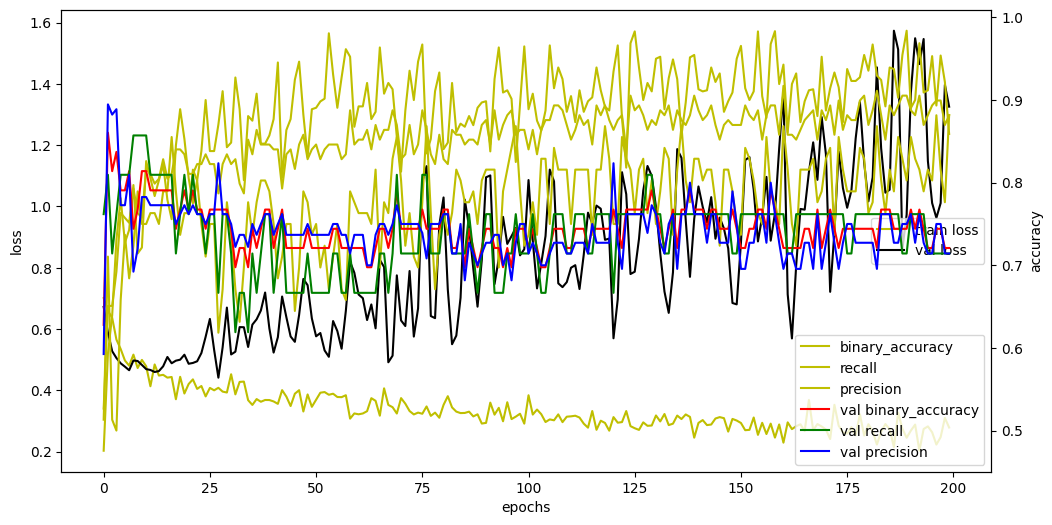

In [277]:
fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'],'y', label='train loss')
loss_ax.plot(hist.history['val_loss'],'k', label='val loss')



acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax
acc_ax.plot(hist.history['binary_accuracy'],'y', label='binary_accuracy')
acc_ax.plot(hist.history['recall_8'],'y', label='recall')
acc_ax.plot(hist.history['precision_8'],'y', label='precision')

acc_ax.plot(hist.history['val_binary_accuracy'],'r', label='val binary_accuracy')
acc_ax.plot(hist.history['val_recall_8'],'g', label='val recall')
acc_ax.plot(hist.history['val_precision_8'],'b', label='val precision')

loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='center right')
acc_ax.legend()
plt.show()

In [278]:
score = model.evaluate(X_test, y_test, verbose=0)
print(score)
print("model loss",score[0])
print("model accuracy",score[1])
print("model recall",score[2])
print("model percision",score[3])

[1.0070655345916748, 0.8351648449897766, 0.8333333134651184, 0.8139534592628479]
model loss 1.0070655345916748
model accuracy 0.8351648449897766
model recall 0.8333333134651184
model percision 0.8139534592628479


In [279]:
# 교차표
y_test.reshape(-1) # 실재값

array([1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0])

In [280]:
y_hat = (model.predict(X_test)>0.5).astype(int).reshape(-1)
y_hat

pd.crosstab(y_test.reshape(-1), y_hat, rownames=['실제값'], colnames=['예측값'])

3/3 [==============================] - 0s 2ms/step


예측값,0,1
실제값,,
0,41,8
1,7,35


## 4. 모델사용(저장, 예측)

In [281]:
model.save('model/07_hearr.h5')
save_model(model,'model/07_hearr.h5')

In [282]:
model2 = load_model('model/07_hearr.h5')

# 분류 분석

1. 데이터 셋 생성 & 전처리
     1-1. 엑셀 -> 데이터프레임 -> ?처리(df.replace('?',np.nan) -> 결측치 처리
         - -> X, y 분리 -> X변수 스케일조정 -> train_test_split함수로 학습셋과 테스트셋분리
         - -> y 변수들의 원핫인코딩
2. 모델 생성(입력13, 출력2) & 학습과정 설정 & 학습
3. 모델 평가(그래프, 평가, 교차표)
4. 모델 사용(저장, 예측)

## 1. 데이터 셋 생성 & 전처리

- 위와 동일 + 원핫인코딩

In [283]:
Y_train = to_categorical(y_train)
Y_test  = to_categorical(y_test)
Y_train.shape, Y_test.shape


((212, 2), (91, 2))

## 2. 모델 생성(입력13, 출력2) & 학습과정 설정 & 학습

In [284]:
model = Sequential()
# model.add(Input(shape=(13,)))
model.add(Dense(units=32, 
                input_dim=13,
                activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=8, activation='relu'))
model.add(Dropout(0.3))
# model.add(Dense(units=1,  activation='sigmoid'))
model.add(Dense(units=2,  activation='softmax'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_71 (Dense)            (None, 32)                448       
                                                                 
 dropout_21 (Dropout)        (None, 32)                0         
                                                                 
 dense_72 (Dense)            (None, 16)                528       
                                                                 
 dropout_22 (Dropout)        (None, 16)                0         
                                                                 
 dense_73 (Dense)            (None, 8)                 136       
                                                                 
 dropout_23 (Dropout)        (None, 8)                 0         
                                                                 
 dense_74 (Dense)            (None, 2)               

In [285]:
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
model.compile(loss='categorical_crossentropy',
             # optimizer=Adam(learning_rate=0.01),
             optimizer='adam',
             metrics=['accuracy', # 정확도
                      metrics.Recall(), # 재현율(실제값 중심)
                      metrics.Precision()]) # 정밀도(예측값 중심)

In [286]:
%%time
hist = model.fit(X_train, Y_train, # 훈련데이터
                epochs=200,
                validation_split=0.2, # 검증데이터를 훈련데이터의 20%로 사용
                verbose=0)

CPU times: user 8.93 s, sys: 723 ms, total: 9.66 s
Wall time: 8.27 s


## 3. 모델 평가(그래프, 평가, 교차표)

In [287]:
hist.history.keys()


dict_keys(['loss', 'accuracy', 'recall_9', 'precision_9', 'val_loss', 'val_accuracy', 'val_recall_9', 'val_precision_9'])

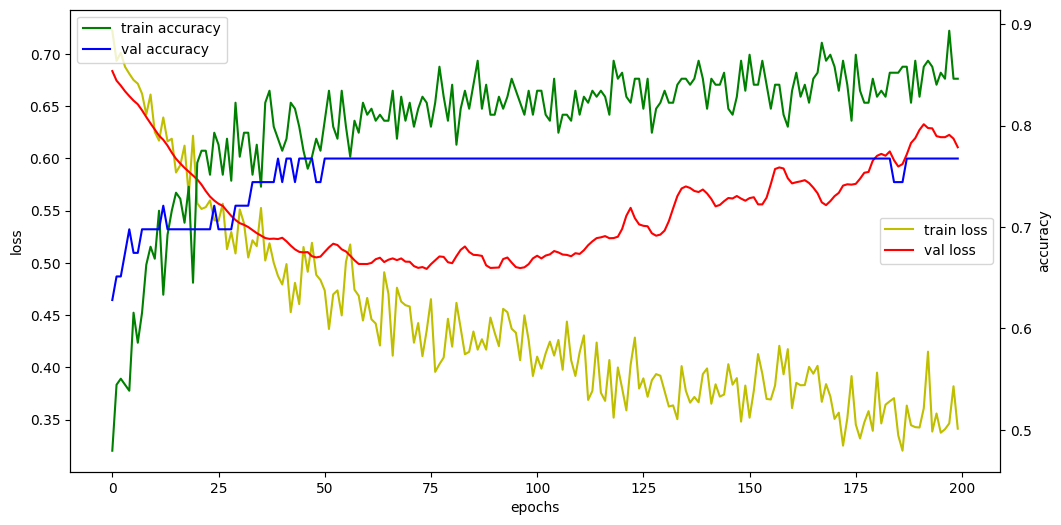

In [288]:
fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend()
plt.show()

In [289]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('model loss : ', score[0])
print('model accuracy : ', score[1])
print('model recall : ', score[2])
print('model precision : ', score[3])

model loss :  0.37920844554901123
model accuracy :  0.8571428656578064
model recall :  0.8571428656578064
model precision :  0.8571428656578064


In [290]:
# 교차표
y_hat = model.predict(X_test).argmax(axis=1)
y_hat

3/3 [==============================] - 0s 3ms/step


array([1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0])

In [291]:
pd.crosstab(y_test.reshape(-1), y_hat,
           rownames=['실제값'],
           colnames=['예측값'])

예측값,0,1
실제값,,
0,42,7
1,6,36


## 4. 모델 사용(저장, 예측)